In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np  
import itertools
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2,random
#import umap,pickle
import seaborn as sns
import time
from skimage.io import imread
from skimage.io import imsave
%matplotlib inline 



1.Data processing




---



parameter : batch size option: [7,14,20,28],  epochs

In [ ]:
#hyperparamters 
nclasses = 3
nchannels = 3 
imagesize=(300,300)
batchsize=20  
epochs=20

In [ ]:
data_dir = '/gdrive/My Drive/REIP/'
model_dir = data_dir + 'model/'  #enter your own dir
model_path = model_dir+'REIP.{epoch:02d}-{val_accuracy:.4f}.hdf5'
result_dir = data_dir+'result/'

df_all = pd.read_csv(data_dir+'label.csv',index_col=None)
df_all['image_path'] = df_all.apply(lambda row:data_dir+row['image_path'],axis=1)
df_all['label_id']=df_all['label_id'].astype(str)


In [ ]:
#get the training dataset, for each category, we choose random 80% for training 
seed = 826

Rclear = df_all[df_all["label_id"]=='0'].sample(400,random_state=seed).copy().reset_index(drop=True)
Rblur = df_all[df_all["label_id"]=='1'].sample(400,random_state=seed).copy().reset_index(drop=True)
Rcharge = df_all[df_all["label_id"]=='2'].sample(320,random_state=seed).copy().reset_index(drop=True)
df = pd.concat([Rclear,Rblur,Rcharge],axis=0,ignore_index=True,sort=False)

In [ ]:
#get the testing dataset 
def getTestData(df_train,df_all,classid):
  R_test = pd.concat([df_train,df_all],axis=0,ignore_index=True,sort=False).drop_duplicates(keep=False) #drop all repeat ones
  Res_test = R_test[R_test["label_id"]==classid].sample(frac=1,random_state=92).copy().reset_index(drop=True)
  return(Res_test)
Rclear_test = getTestData(Rclear,df_all,'0')
Rblur_test = getTestData(Rblur,df_all,'1')
Rcharge_test = getTestData(Rcharge,df_all,'2')

df_test = pd.concat([Rclear_test,Rblur_test,Rcharge_test],axis=0,ignore_index=True,sort=False)

In [ ]:
df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['label_id'],random_state=5555)
print("Number of training and validation samples are respectively:", len(df_train), "and",len(df_val))

Number of training and validation samples are respectively: 896 and 224


2.Model setting


---






In [ ]:
# Rescale all images by 1./255 and apply image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=[0.9, 1.2],
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='nearest',
                rescale=1./255
                )

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255
                )#normalize the intensity of the RGB value

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
                df_train,
                x_col = 'image_path',  
                y_col ='label_id',
                target_size=imagesize,  
                batch_size=batchsize,
                shuffle = True, #every epoch, image will be shuffled so each batch will be different from last epoch
                class_mode='categorical')


validation_generator = validation_datagen.flow_from_dataframe(
                df_val,
                x_col = 'image_path',  
                y_col ='label_id',
                target_size=imagesize,  
                batch_size=batchsize,
                shuffle = False, # make sure my reference is the same so i can compare if my training results are improving. 
                class_mode='categorical')

Found 896 validated image filenames belonging to 3 classes.
Found 224 validated image filenames belonging to 3 classes.


Basemodel option :https://keras.io/api/applications/
only change name, don't change parameter

In [ ]:
basemodel = tf.keras.applications.DenseNet121(weights='imagenet',include_top=False,input_shape=(imagesize[0],imagesize[1],nchannels))
basemodel.trainable = True

29097984/29084464 [==============================] - 1s 0us/step


* Activation function in dense layer can be change [relu,sigmoid....]
* number of neurons can be changed, you can add one 256 neurons layer between
* pooling layer can be change(globalaverage pool, gloabalmax pool]






>



In [ ]:
#Build model    
model = tf.keras.Sequential()
model.add(basemodel)
model.add(tf.keras.layers.GlobalAveragePooling2D())  #Join the global average pooling layer
model.add(tf.keras.layers.Dense(512,activation='relu'))  #Add fully connected layer and do densification 
model.add(tf.keras.layers.Dropout(rate=0.25))  #Add Dropout layer to prevent overfitting
model.add(tf.keras.layers.Dense(128,activation='relu'))  #Add fully connected layer do densification 
model.add(tf.keras.layers.Dropout(rate=0.25))
model.add(tf.keras.layers.Dense(nclasses,activation='softmax'))  #Add output layer (2 categories)
model.summary()   #Print each layer parameter information 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 9, 9, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

Inital learning rate can be change

In [ ]:
#Compile model
initial_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), #Use 'Adam' optimizer, the learning rate is 0.0001
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #Cross entropy loss function
              metrics=["accuracy"]) #Evaluation function

* factor and patience in reduce function can be changed



* you can remove the earlystop func in the next cell, it is optional to prevent overfitting and for saving time




In [ ]:
#Callback function 1: Learning rate decay, after each epoch, the learning rate is modified based on performance, 
reduce_lr = ReduceLROnPlateau(
                                monitor='val_loss', #The value to be monitored
                                factor=0.7,  
                                patience=2,  #When patience epochs are past and the model performance does not improve, the action of reducing the learning rate will be triggered
                                mode='auto', #When the monitoring value is val_acc, the mode should be max. When the monitoring value is val_loss, the mode should be min. In auto mode, the evaluation criterion is automatically inferred from the name of the monitored value
                                verbose=1 #If True, output a message for each update, default value: False
                             )
#Callback function 2: Save the optimal model
checkpoint = ModelCheckpoint(
                                filepath=model_path, # Path at which to save the model file.
                                monitor='val_accuracy', #Need to monitor the value
                                save_weights_only=True, #If set to True, only the model weight will be saved, otherwise the entire model (including model structure, configuration information, etc.) will be saved
                                save_best_only=True, #When set to True, the current model will only be saved when the monitoring value is improved
                                mode='auto', #When the monitoring value is val_acc, the mode should be max. When the monitoring value is val_loss, the mode should be min. In auto mode, the evaluation criterion is automatically inferred from the name of the monitored value
                                verbose=1 #If True, output a message for each update, default value: False
                            )
#optional
earlystop = EarlyStopping(
                                monitor="val_accuracy", #If the val_accuracy is not improved over patience of epoch, the running will be terminated
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                baseline=None,
                                restore_best_weights=True, #Restore the best weights
)

In [ ]:
model.save(model_dir+'REIP.h5') #If change the model in building model cell, change name accordingly to prevent overlap and misuse

3.Start training

---



---





In [ ]:
#Start training
start_time = time.time()
history = model.fit(x=train_generator,   #Enter training set
                    steps_per_epoch=train_generator.n // batchsize, #The number of training steps included in an epoch
                    epochs=epochs, #Training model iterations
                    validation_data=validation_generator,  #Enter validation set
                    validation_steps=validation_generator.n // batchsize, #The number of validation steps included in an epoch
                    workers = 16,
                    callbacks=[checkpoint, earlystop, reduce_lr] #Execute callback function, early stop is optinal
                    )
total_time = time.time() - start_time
print(total_time)

If your run the training model several time, the name of dense layer could be changed, enter an intermediate layer

4.Get features

---



---



In [ ]:
#prediction
#load in model and weight 
weightfile = model_dir+'REIP.10-0.8500.hdf5' #reading the model you trained above
model = keras.models.load_model(model_dir+'REIP.h5') #load the basemodel, 
model.load_weights(weightfile) #add the weight file that just trained to the basemodel 
#create a model to predict the feature space. 
feature_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('dense_1').output) #take the output of the one intermediate layer that grabs the feature of each image 
#feature_model is not needed for application case

5.Prediction

---






 Prediction of single image

In [ ]:
def prediction(image_folder_path): # ex : '/gdrive/My Drive/REIP/imagedata/clear/27.tif')
  '''This prediction function take input picture file and return the predicted class'''
  reip_dict = {0:'clear', 1:'blur', 2:'surface_charge'}             # label dict
  rd_image = cv2.cvtColor(cv2.imread(image_folder_path), cv2.COLOR_BGR2RGB)     # read image
  cropre_pic = np.expand_dims(cv2.resize(rd_image[0:890, :],(300,300)),axis=0)    # crop and resize
  predict = reip_dict.get(np.argmax(model(cropre_pic)[0]))            # predict and get classes
  pre_string = f'It is predicted to be {predict}.'
  return pre_string

In [ ]:
df_test

In [ ]:
path = '/gdrive/My Drive/REIP/imagedata/clear/34.tif' #choose a pic from above test set or 未crop圖片資料夾 to check
prediction(path)

'It is predicted to be clear.'

multiple images

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255
                )

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
                df_test,
                x_col = 'image_path', 
                y_col = None, 
                target_size=imagesize,  
                batch_size=batchsize,
                shuffle = False,
                class_mode=None)
#prediction of the label 
pred=model.predict(
    test_generator,
    steps=test_generator.n//batchsize,
    workers=8,
    verbose=1) #set 0 to not show output
#prediction of the intermediate layer, not needed for application
featpred=feature_model.predict(
    test_generator,
    workers=8,
    steps=test_generator.n//batchsize,
    verbose=1) #set 0 to not show output
print(pred.shape)
print(featpred.shape)

Found 280 validated image filenames.
14/14 [==============================] - 4s 246ms/step
(280, 3)
(280, 128)


In [ ]:
reip_dict = {0:'clear', 1:'blur', 2:'surface_charge'}
pred_idx=np.argmax(pred,axis=1) # get predict index. 
df_test['pred_index'] = pred_idx
df_test['pred_label'] = df_test['pred_index'].map(reip_dict.get) 

In [ ]:
df_test

,image_path,image_id,label_id,label_text,pred_index,pred_label
0,/gdrive/My Drive/REIP/imagedata/clear/99.tif,99,0,clear,0,clear
1,/gdrive/My Drive/REIP/imagedata/clear/497.tif,497,0,clear,0,clear
2,/gdrive/My Drive/REIP/imagedata/clear/336.tif,336,0,clear,0,clear
3,/gdrive/My Drive/REIP/imagedata/clear/294.tif,294,0,clear,0,clear
4,/gdrive/My Drive/REIP/imagedata/clear/318.tif,318,0,clear,1,blur
...,...,...,...,...,...,...
275,/gdrive/My Drive/REIP/imagedata/surface_charge...,354,2,surface_charge,0,clear
276,/gdrive/My Drive/REIP/imagedata/surface_charge...,34,2,surface_charge,2,surface_charge
277,/gdrive/My Drive/REIP/imagedata/surface_charge...,83,2,surface_charge,2,surface_charge
278,/gdrive/My Drive/REIP/imagedata/surface_charge...,336,2,surface_charge,2,surface_charge


In [ ]:
correct = df_test[df_test["label_text"]==df_test['pred_label']]

In [ ]:
accuracy = len(correct)/len(df_test)
accuracy

0.8392857142857143




* Below just for visualize output and raw features






In [ ]:
#save features into the test dataframe
num_features = featpred.shape[1]
featcols = ['Feature{0:03d}'.format(ii) for ii in range(num_features)]
for ii in range(len(featcols)):
  df_test[featcols[ii]] = featpred[:,ii]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


In [ ]:
print(df_test.head())
print(result_dir)

                                      image_path  image_id label_id  \
0   /gdrive/My Drive/REIP/imagedata/clear/99.tif        99        0   
1  /gdrive/My Drive/REIP/imagedata/clear/497.tif       497        0   
2  /gdrive/My Drive/REIP/imagedata/clear/336.tif       336        0   
3  /gdrive/My Drive/REIP/imagedata/clear/294.tif       294        0   
4  /gdrive/My Drive/REIP/imagedata/clear/318.tif       318        0   

  label_text  pred_index pred_label  Feature000  Feature001  Feature002  \
0      clear           0      clear    1.583201    0.000000         0.0   
1      clear           0      clear    4.615377    0.863142         0.0   
2      clear           0      clear    3.082671    0.000000         0.0   
3      clear           0      clear    0.000000    0.422153         0.0   
4      clear           1       blur    0.000000    0.528119         0.0   

   Feature003  ...  Feature118  Feature119  Feature120  Feature121  \
0         0.0  ...    0.000000    0.000000    0.0000

Uncomment below cell if you want to save the raw feature and predict class in to csv file

In [ ]:
#df_test.to_csv(result_dir+'df_test_0309nick.csv',index=None)

image number 227 is labeled as surface_charge. It's predicted as surface_charge, which is True


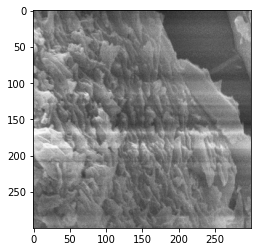

image number 166 is labeled as blur. It's predicted as blur, which is True


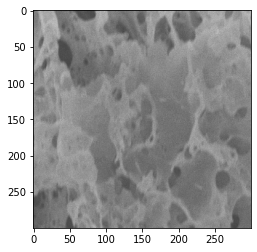

image number 171 is labeled as blur. It's predicted as blur, which is True


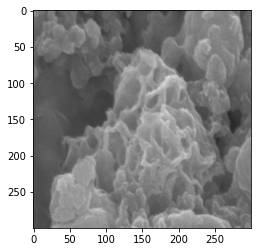

image number 146 is labeled as blur. It's predicted as blur, which is True


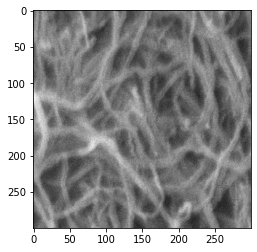

image number 262 is labeled as surface_charge. It's predicted as surface_charge, which is True


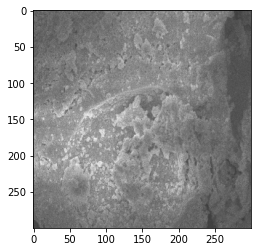

image number 60 is labeled as clear. It's predicted as clear, which is True


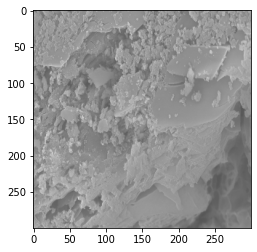

image number 159 is labeled as blur. It's predicted as surface_charge, which is False


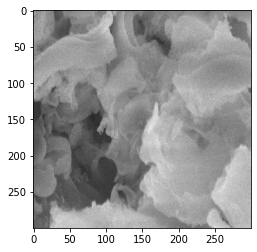

image number 259 is labeled as surface_charge. It's predicted as clear, which is False


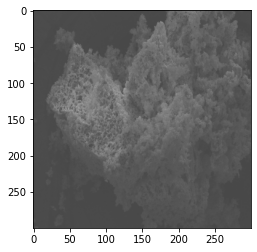

image number 271 is labeled as surface_charge. It's predicted as clear, which is False


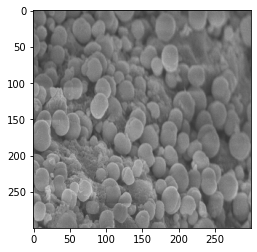

image number 131 is labeled as blur. It's predicted as blur, which is True


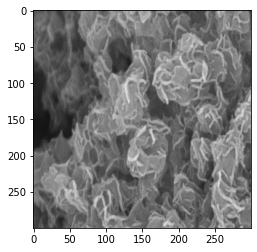

In [ ]:
#show image and classification results
for i in range(10):
  n = random.randint(0,pred.shape[0]) 
  correct = (df_test.iloc[n].label_text == df_test.iloc[n].pred_label)
  print('image number {} is labeled as {}. It\'s predicted as {}, which is {}'.format(n, df_test.iloc[n].label_text, df_test.iloc[n].pred_label,correct ))
  img = Image.open(df_test.iloc[n].image_path)
  plt.imshow(img)
  plt.show()

load back the result and the feature, if neccessary

In [ ]:
df_test= pd.read_csv(result_dir+'df_test_0306nick.csv',index_col=None)
featpred = df_test.iloc[:,-128:]
print(featpred.shape)

(280, 128)
